In [15]:
import pandas as pd
import numpy as np

foreign = pd.read_csv("Foreign_Exchange_Rates.csv", index_col = 'Unnamed: 0', parse_dates = True, na_values=["ND"])

In [16]:
foreign.fillna(method="ffill", inplace=True)

In [17]:
foreign.columns

Index(['Time Serie', 'AUSTRALIA - AUSTRALIAN DOLLAR/US$',
       'EURO AREA - EURO/US$', 'NEW ZEALAND - NEW ZELAND DOLLAR/US$',
       'UNITED KINGDOM - UNITED KINGDOM POUND/US$', 'BRAZIL - REAL/US$',
       'CANADA - CANADIAN DOLLAR/US$', 'CHINA - YUAN/US$',
       'HONG KONG - HONG KONG DOLLAR/US$', 'INDIA - INDIAN RUPEE/US$',
       'KOREA - WON/US$', 'MEXICO - MEXICAN PESO/US$',
       'SOUTH AFRICA - RAND/US$', 'SINGAPORE - SINGAPORE DOLLAR/US$',
       'DENMARK - DANISH KRONE/US$', 'JAPAN - YEN/US$',
       'MALAYSIA - RINGGIT/US$', 'NORWAY - NORWEGIAN KRONE/US$',
       'SWEDEN - KRONA/US$', 'SRI LANKA - SRI LANKAN RUPEE/US$',
       'SWITZERLAND - FRANC/US$', 'TAIWAN - NEW TAIWAN DOLLAR/US$',
       'THAILAND - BAHT/US$'],
      dtype='object')

In [18]:
foreign.set_index(keys=foreign["Time Serie"], inplace=True)
foreign.drop(columns=["Time Serie"], inplace=True)
foreign.index = pd.to_datetime(foreign.index)

In [19]:

foreign.sort_index(inplace=True)


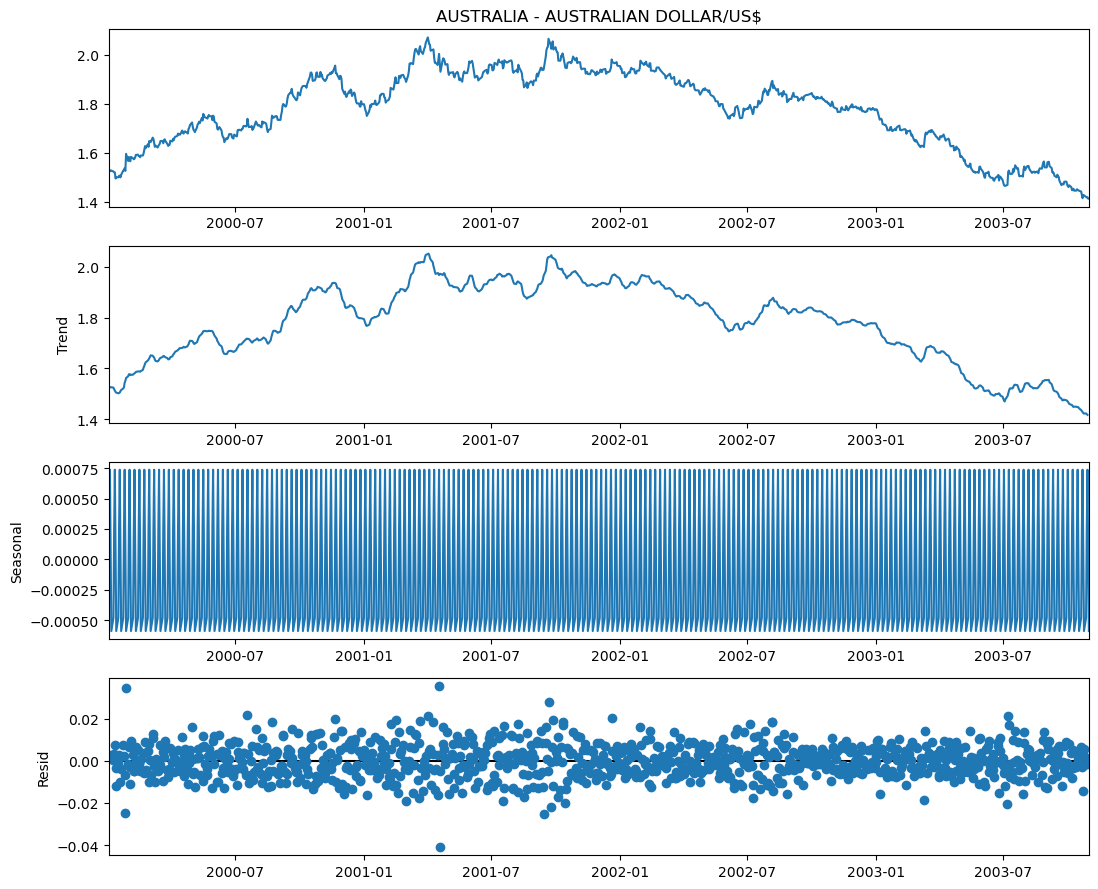

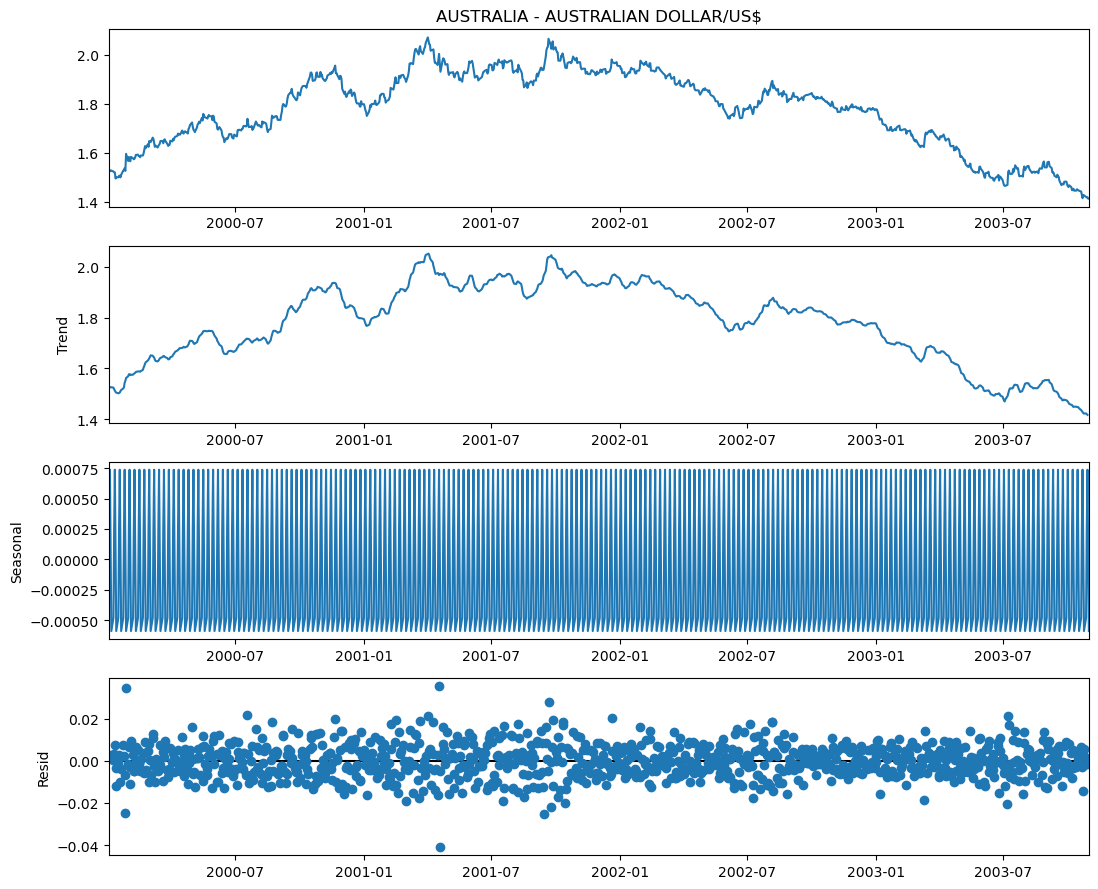

In [20]:
from statsmodels.tsa.seasonal import seasonal_decompose
from pylab import rcParams
rcParams['figure.figsize'] = 11, 9
decompose = seasonal_decompose(foreign["AUSTRALIA - AUSTRALIAN DOLLAR/US$"][:1000])
decompose.plot()

In [21]:
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(foreign["AUSTRALIA - AUSTRALIAN DOLLAR/US$"])
print('p-value = ' + str(adf_test[1]))

p-value = 0.4549867172429758


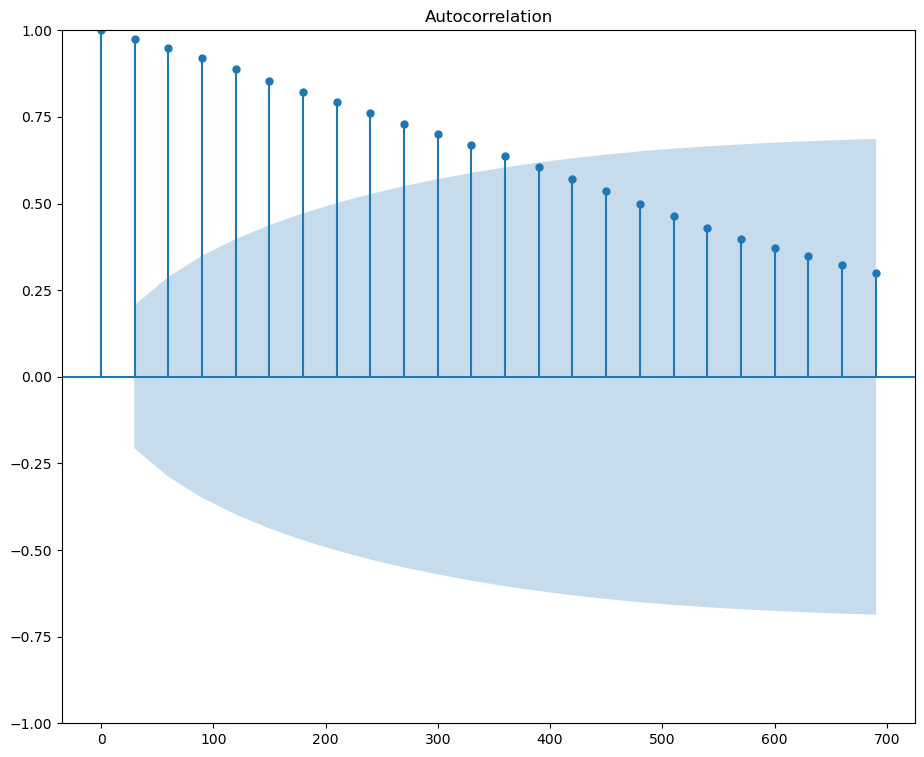

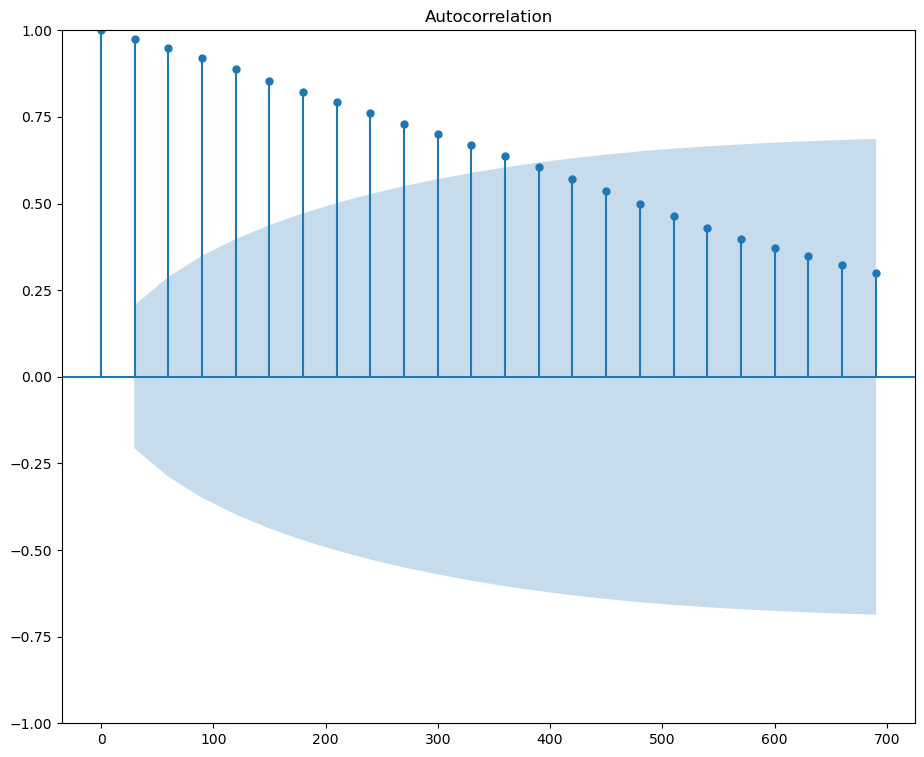

In [22]:
x = [ x for x in range(0, 720, 30)]

from statsmodels.graphics.tsaplots import plot_acf
plot_acf(foreign["AUSTRALIA - AUSTRALIAN DOLLAR/US$"], lags=x)

In [23]:
df = pd.DataFrame({"Australia": foreign["AUSTRALIA - AUSTRALIAN DOLLAR/US$"]})

In [27]:

from sklearn.preprocessing import StandardScaler

scalers = {}
for x in df.columns:
  scalers[x] = StandardScaler().fit(df[x].values.reshape(-1, 1))

norm_df = df.copy()
for i, key in enumerate(scalers.keys()):
  norm = scalers[key].transform(norm_df.iloc[:, i].values.reshape(-1, 1))
  norm_df.iloc[:, i] = norm

In [30]:
norm_df.describe()

,Australia
count,5.217000e+03
mean,-5.321175e-16
std,1.000096e+00
min,-1.576861e+00
25%,-8.024878e-01
50%,-7.704592e-02
75%,3.644468e-01
max,2.739463e+00


In [62]:
import torch
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from datetime import date, datetime
import os
def generate_sequences(df: pd.DataFrame, tw: int, pw: int, target_columns, drop_targets=False):
  '''
  df: Pandas DataFrame of the univariate time-series
  tw: Training Window - Integer defining how many steps to look back
  pw: Prediction Window - Integer defining how many steps forward to predict

  returns: dictionary of sequences and targets for all sequences
  '''
  data = dict()
  L = len(df)
  for i in range(L-tw):
    if drop_targets:
      df.drop(target_columns, axis=1, inplace=True)
    sequence = df[i:i+tw].values
    target = df[i+tw:i+tw+pw][target_columns].values
    data[i] = {'sequence': sequence, 'target': target}
  return data

class SequenceDataset(Dataset):

  def __init__(self, data):
    self.data = data

  def __getitem__(self, idx):
    sample = self.data[idx]
    return torch.Tensor(sample['sequence']), torch.Tensor(sample['target'])
  
  def __len__(self):
    return len(self.data)

In [63]:
BATCH_SIZE = 16
nhid = 50
nout = 1
sequence_len = 180
n_dnn_layers = 5
ninp = 1
split = 0.8

sequences = generate_sequences(norm_df.Australia.to_frame(), sequence_len, nout, 'Australia')
dataset = SequenceDataset(sequences)

train_len = int(len(dataset)*split)
lens = [train_len, len(dataset)-train_len]
train_ds, test_ds = random_split(dataset, lens)
trainloader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
testloader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

In [68]:

class LSTMForecaster(nn.Module):


  def __init__(self, n_features, n_hidden, n_outputs, sequence_len, n_lstm_layers=1, n_deep_layers=10, use_cuda=False, dropout=0.2):
    '''
    n_features: number of input features (1 for univariate forecasting)
    n_hidden: number of neurons in each hidden layer
    n_outputs: number of outputs to predict for each training example
    n_deep_layers: number of hidden dense layers after the lstm layer
    sequence_len: number of steps to look back at for prediction
    dropout: float (0 < dropout < 1) dropout ratio between dense layers
    '''
    super().__init__()

    self.n_lstm_layers = n_lstm_layers
    self.nhid = n_hidden
    self.use_cuda = use_cuda # set option for device selection

    # LSTM Layer
    self.lstm = nn.LSTM(n_features,
                        n_hidden,
                        num_layers=n_lstm_layers,
                        batch_first=True) # As we have transformed our data in this way
    
    # first dense after lstm
    self.fc1 = nn.Linear(n_hidden * sequence_len, n_hidden) 
    # Dropout layer 
    self.dropout = nn.Dropout(p=dropout)

    # Create fully connected layers (n_hidden x n_deep_layers)
    dnn_layers = []
    for i in range(n_deep_layers):
      # Last layer (n_hidden x n_outputs)
      if i == n_deep_layers - 1:
        dnn_layers.append(nn.ReLU())
        dnn_layers.append(nn.Linear(nhid, n_outputs))
      # All other layers (n_hidden x n_hidden) with dropout option
      else:
        dnn_layers.append(nn.ReLU())
        dnn_layers.append(nn.Linear(nhid, nhid))
        if dropout:
          dnn_layers.append(nn.Dropout(p=dropout))
    # compile DNN layers
    self.dnn = nn.Sequential(*dnn_layers)

  def forward(self, x):

    # Initialize hidden state
    hidden_state = torch.zeros(self.n_lstm_layers, x.shape[0], self.nhid)
    cell_state = torch.zeros(self.n_lstm_layers, x.shape[0], self.nhid)

    # move hidden state to device
    if self.use_cuda:
      hidden_state = hidden_state.to(device)
      cell_state = cell_state.to(device)
        
    self.hidden = (hidden_state, cell_state)

    # Forward Pass
    x, h = self.lstm(x, self.hidden) # LSTM
    x = self.dropout(x.contiguous().view(x.shape[0], -1)) # Flatten lstm out 
    x = self.fc1(x) # First Dense
    return self.dnn(x) # Pass forward through fully connected DNN.

In [100]:
nhid = 20 # Number of nodes in the hidden layer
n_dnn_layers = 2 # Number of hidden fully connected layers
nout = 1 # Prediction Window
sequence_len = 180 # Training Window

# Number of features (since this is a univariate timeseries we'll set
# this to 1 -- multivariate analysis is coming in the future)
ninp = 1

# Device selection (CPU | GPU)
USE_CUDA = False
device = 'cpu'

# Initialize the model
model = LSTMForecaster(ninp, nhid, nout, sequence_len, n_deep_layers=n_dnn_layers, use_cuda=USE_CUDA).to(device)

In [101]:
lr = 4e-4
n_epochs = 20

# Initialize the loss function and optimizer
criterion = nn.MSELoss().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

0 - train: 0.13121265080197161, valid: 0.03353428085231119
1 - train: 0.054274551470233384, valid: 0.025736717544200403
2 - train: 0.05240015348093027, valid: 0.015085878235007089
3 - train: 0.04571982774052368, valid: 0.01772434495034672
4 - train: 0.04162491110906717, valid: 0.026613831412904555
5 - train: 0.040204070864683125, valid: 0.011773279978938046
6 - train: 0.03996540098432526, valid: 0.015059115269058754
7 - train: 0.040126545313908996, valid: 0.010620427218132786
8 - train: 0.040404169979798364, valid: 0.008203095926474484
9 - train: 0.03902446313675834, valid: 0.01196269401984792
10 - train: 0.03746158819074234, valid: 0.010724284279618471
11 - train: 0.035892253585783136, valid: 0.009239621216519958
12 - train: 0.034725283034168095, valid: 0.01057423504128579
13 - train: 0.03701308387353927, valid: 0.011214181884295411
14 - train: 0.03645609772997905, valid: 0.013570989969940413
15 - train: 0.03691079162165107, valid: 0.007884732510391918
16 - train: 0.034407225118363756

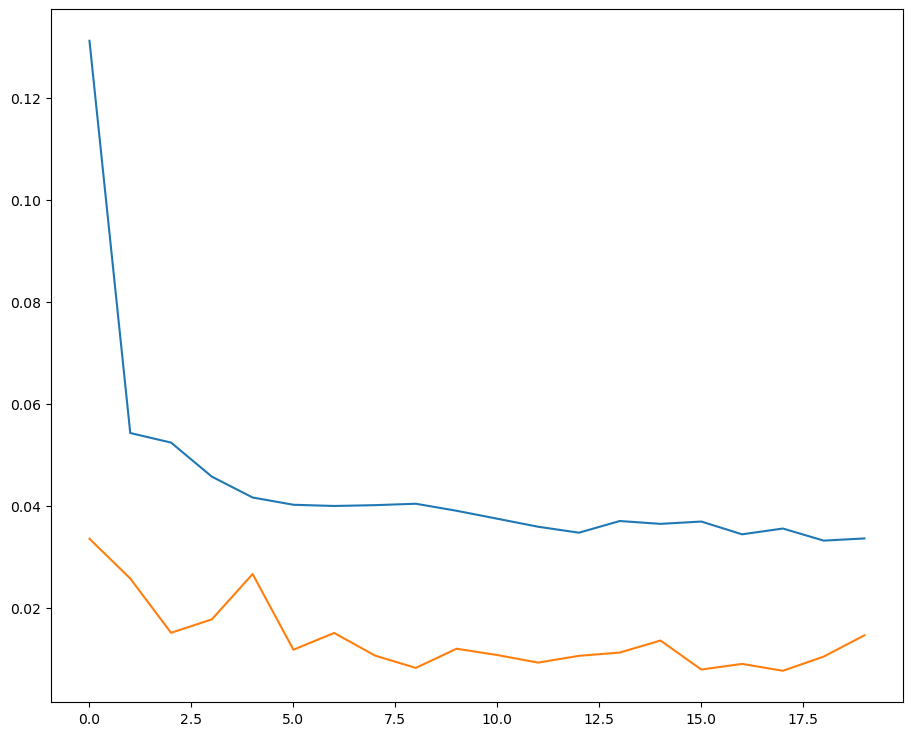

In [102]:
def plot_losses(tr, va):
  import matplotlib.pyplot as plt
  fig, ax = plt.subplots()
  ax.plot(tr, label='train')
  ax.plot(va, label='validation')
  plt.show()
t_losses, v_losses = [], []
# Loop over epochs
for epoch in range(n_epochs):
    train_loss, valid_loss = 0.0, 0.0
 
    # train step
    model.train()
    # Loop over train dataset
    for x, y in trainloader:
        optimizer.zero_grad()
        # move inputs to device
        x = x.to(device)
        y  = y.squeeze().to(device)
        # Forward Pass
        preds = model(x).squeeze()
        loss = criterion(preds, y) # compute batch loss
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
    epoch_loss = train_loss / len(trainloader)
    t_losses.append(epoch_loss)
  
  # validation step
    model.eval()
  # Loop over validation dataset
    for x, y in testloader:
        with torch.no_grad():
            x, y = x.to(device), y.squeeze().to(device)
            preds = model(x).squeeze()
            error = criterion(preds, y)
        valid_loss += error.item()
    valid_loss = valid_loss / len(testloader)
    v_losses.append(valid_loss)
      
    print(f'{epoch} - train: {epoch_loss}, valid: {valid_loss}')
plot_losses(t_losses, v_losses)

In [103]:
df_for_pred=pd.DataFrame({"Australia":foreign["CANADA - CANADIAN DOLLAR/US$"]})
df_for_pred

,Australia
Time Serie,
2000-01-03,1.4465
2000-01-04,1.4518
2000-01-05,1.4518
2000-01-06,1.4571
2000-01-07,1.4505
...,...
2019-12-25,1.3160
2019-12-26,1.3124
2019-12-27,1.3073


In [104]:
norm_df = df_for_pred.copy()
for i, key in enumerate(scalers.keys()):
  norm = scalers[key].transform(norm_df.iloc[:, i].values.reshape(-1, 1))
  norm_df.iloc[:, i] = norm

In [105]:
BATCH_SIZE = 16
nhid = 50
nout = 1
sequence_len = 180
n_dnn_layers = 5
ninp = 1
split = 0.8

sequences = generate_sequences(norm_df.Australia.to_frame(), sequence_len, nout, 'Australia')
dataset = SequenceDataset(sequences)

In [125]:
def make_predictions_from_dataloader(model, unshuffled_dataloader):
    model.eval()
    predictions = []
    for x, y in unshuffled_dataloader:
        with torch.no_grad():
            p = model(x)
            predictions.append(p)
    predictions = torch.cat(predictions).numpy()
    return predictions.squeeze()

In [126]:
unshuffled_dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)
P = make_predictions_from_dataloader(model, unshuffled_dataloader)

In [127]:
pdf = pd.DataFrame([P], index=['predictions', 'actuals']).T
import plotly.express as px
fig = px.line(pdf)
fig.update_layout(
    autosize=False,
    width=2400,
    height=800,)
fig.show()